# Energy Efficiency
Problem Set 2

In [73]:
import os
import io
import sys
import glob
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
from scipy.stats import norm

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import HTML, display as d
from IPython.core.magic import register_cell_magic
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
# plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [74]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
tableau20 = [
    (r / 255., g / 255., b / 255.)
    for r, g, b in tableau20
]


class data_sources(object):
    '''Stores all urls and filenames to save/load data'''
    uLL84 = 'http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx'
#     uPLUTO = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip'
    uPLUTO = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/{}_mappluto_16v2.zip'

    fLL84 = 'data/nyc_benchmarking_disclosure_data_reported_in_2016.csv'
    fPLUTO = 'data/nyc_pluto_16v2.csv'
    
    iPLUTOs = ['bx', 'bk', 'mn', 'qn', 'si']
    

@register_cell_magic
def report_change(line, cell):
    '''Prints the change in a (globally defined) dataframe length
    
    Example:
        %%report_change df
        df = df.dropna(subset=['some_column'])
    prints: Data Size: {size before} -> {size after} ({percent change}%)
    '''
    parts = filter(len, (line or 'df').split(' '))
    if len(parts) == 1:
        parts += parts
    df_before, df_after = parts[:2]
    
    len_before = len(globals().get(df_before, []))
    get_ipython().run_cell(cell)
    len_after = len(globals().get(df_after, []))
    print('Data Size: {} before = {} samples, {} after = {} samples (∆{}, {:.3f}%)'.format(
        df_before, len_before, 
        df_after, len_after, len_after - len_before,
        100.*(len_after - len_before) / (len_before or 1)))
    

## Data Loading & Preparation

[LL84](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml), 
[PLUTO](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page), 
[Population](http://www1.nyc.gov/site/planning/data-maps/nyc-population.page)

In [75]:
if os.path.isfile(data_sources.fLL84):
    df84 = pd.read_csv(data_sources.fLL84)
else:
    print('Downloading...')
    df84 = pd.read_excel(data_sources.uLL84)
    # Remove ^2 symbol
    df84.columns = df.columns.str.replace(u'²', '_2')
    # Cache file
    df84.to_csv(data_sources.fLL84, encoding='utf-8', index=False)

print(df84.values.shape)
df84.head()

(13223, 57)


,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft_2),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft_2),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft_2),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1437732.8,14515.6,1507302.8,431480.2,201.4,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN
2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,2 AVENUE,10021.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,166433.0,Not Available,Not Available,Not Available,Not Available,1964,1.0,95.0,Whole Building,Whole Building,80.0,44.9,44.5,8.2,0.2,106.7,105.2,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2739020.0,27390.2,4737201.3,1365852.0,538.4,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual
3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1341.0,LEXINGTON AVENUE,10128.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,114939.0,Not Available,Not Available,Not Available,Not Available,1960,1.0,95.0,Whole Building,Whole Building,10

In [76]:
if os.path.isfile(data_sources.fPLUTO):
    # Read from cache
    dfPLUTO = pd.read_csv(data_sources.fPLUTO)
else:
    print('Downloading...')
    # Get zip buffer
    for id in data_sources.iPLUTOs:
        print('downloading', id)
        url = data_sources.uPLUTO.format(id.lower())
        remotezip = urllib.urlopen(url).read()

        # Open in memory
        with zipfile.ZipFile(io.BytesIO(remotezip)) as z:
            # extract to directory
            zipdir = os.path.join(
                os.path.basename(data_sources.fPLUTO),
                os.path.splitext(os.path.basename(url))[0]
            )
            z.extractall(zipdir)

    # Pardon the redundant code!
    dfs = []
    for id in data_sources.iPLUTOs:
        print('loading', id)
        # Read all shp files
        dfs.append(gpd.read_file( 
            os.path.join(
                os.path.basename(data_sources.fPLUTO),
                os.path.splitext(os.path.basename(data_sources.uPLUTO.format(id.lower())))[0], 
                '{}MapPLUTO.shp'.format(id.upper())) 
        ))
    dfPLUTO = pd.concat(dfs)

print(dfPLUTO.values.shape)
dfPLUTO.head()

(857237, 88)


,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,BX,2318,22,201,51.0,1024.0,7.0,8,10454,E060,40,3800,2.0,1.0,1A,270 EAST 137 STREET,M1-4/R7A,NaN,NaN,NaN,NaN,NaN,MX-13,NaN,NaN,NaN,N,K7,5.0,0,P,SOBRO DEVELOPMENT COR,5139,11700,11700,0,11700,0,0,0,0,0,2,1,3.0,0,3,39.67,100.0,39.00,100.0,NaN,0.0,Y,3.0,5.0,138600.0,831150.0,0.0,432000.0,1911,2000,0,NaN,NaN,2.28,4.0,2.0,4.0,2,2.023180e+09,0,51,1004162,234443,6a,NaN,209S002,20902.0,E-227,0.0,NaN,1,16V2,0,330.014939,5994.020237,"POLYGON ((1004162.726199999 234386.1791999936,..."
1,BX,2296,42,201,19.0,1009.0,7.0,8,10454,E060,40,4700,2.0,1.0,1A,69 BRUCKNER BOULEVARD,M1-2/R6A,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,S3,4.0,0,P,"MPM 67, LLC",2000,5120,1280,3840,0,1280,0,0,0,0,2,1,4.0,3,4,20.00,100.0,20.00,64.0,NaN,0.0,N,5.0,5.0,24211.0,35042.0,0.0,0.0,1915,0,0,NaN,NaN,2.56,3.0,2.0,3.0,2,2.022960e+09,0,19,1004696,233144,6a,NaN,209S010,20902.0,NaN,0.0,NaN,1,16V2,0,243.507148,2035.046764,"POLYGON ((1004680.847200006 233094.8020000011,..."
2,BX,2296,11,201,19.0,1009.0,7.0,8,10454,E060,40,4700,2.0,1.0,1A,348 EAST 134 STREET,M1-2/R6A,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,E9,6.0,0,P,MACK REALTY DEVELOPME,2500,4875,4875,0,0,0,0,4875,0,0,2,1,1.0,0,1,25.00,100.0,25.00,85.0,NaN,3.0,N,5.0,2.0,18000.0,188100.0,0.0,170100.0,2008,0,0,NaN,NaN,1.95,3.0,2.0,3.0,2,2.022960e+09,0,19,1004633,233295,6a,NaN,209S010,20902.0,NaN,0.0,NaN,1,16V2,0,250.985214,2432.957975,"POLYGON ((1004668.343999997 233334.0714000016,..."
3,BX,2296,51,201,19.0,1009.0,7.0,8,10454,E060,40,4700,2.0,1.0,1A,51 BRUCKNER BOULEVARD,M1-2/R6A,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,S4,4.0,0,P,51 BRUCKNER LLC,2000,5120,700,4420,0,700,0,0,0,0,2,1,4.0,4,5,20.00,100.0,20.00,64.0,NaN,0.0,N,5.0,5.0,10203.0,13989.0,0.0,0.0,1915,2003,0,NaN,NaN,2.56,3.0,2.0,3.0,2,2.022960e+09,0,19,1004537,233231,6a,NaN,209S010,20902.0,NaN,0.0,NaN,1,16V2,0,245.902974,2111.489026,"POLYGON ((1004571.2324 233271.8015999943, 1004..."
4,BX,2319,37,201,51.0,1026.0,7.0,8,10451,E060,40,3800,2.0,1.0,1A,2441 3 AVENUE,M1-3/R8,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,D9,3.0,0,P,225 EAST REALTY PARTN,35049,83936,46640,37296,1000,0,4000,17364,24276,0,2,2,5.0,46,50,192.58,205.0,71.25,135.0,NaN,0.0,Y,3.0,5.0,315450.0,1294650.0,0.0,67403.0,1917,2008,0,NaN,NaN,2.39,7.2,5.0,6.5,2,2.023190e+09,0,51,1003568,234178,6a,NaN,209S001,20902.0,NaN,0.0,NaN,1,16V2,0,791.368728,35247.169036,"POLYGON ((1003446.053599998 234160.9472000003,..."


<IPython.core.display.Javascript object>

In [77]:
# Rename site EUI for convenience
eui_label = 'Weather Normalized Source EUI (kBtu/ft_2)'
df84['eui'] = df84[eui_label]
# Rename BBL for convenience
df84['BBL'] = df84['NYC Borough, Block and Lot (BBL)']

In [78]:
%%report_change df84 df
# Merging LL84 and PLUTO on BBL
df = pd.merge(df84, dfPLUTO, on='BBL', suffixes=('', '__'), how='inner')
df.head()

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft_2),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft_2),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft_2),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,BBL,Borough__,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,115.7,1.003360e+09,MN,336,5,103,12.00,1007.0,1.0,1,10002,L018,7,7600,1.0,3.0,2B,15 BIALYSTOKER PLACE,R8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,D3,3.0,0,NaN,UJC ORENSTEIN PRESERV,18375,98052,0,98052,0,0,0,0,0,0,2,1,11.0,128,128,107.04,175.47,93.00,106.0,NaN,2.0,Y,0.0,1.0,423000.0,7086600.0,423000.0,7077292.0,1982,0,0,NaN,NaN,5.34,6.02,0.0,6.5,1,0,12,988879,200069,12c,Y,101N082,10201.0,NaN,1.003360e+09,08/27/2012,1,16V2,0,560.747445,18843.947373,"POLYGON ((988978.3273999989 200091.3111999929,..."
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Buildin

Data Size: df84 before = 13223 samples, df after = 13127 samples (∆-96, -0.726%)


In [79]:
df.columns.values

array(['Record Number', 'Order', 'NYC Borough, Block and Lot (BBL)',
       'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identification Numbers (BINs)',
       'Property Name', 'Parent Property Id', 'Parent Property Name',
       'Street Number', 'Street Name', 'Zip Code', 'Borough',
       'DOF Benchmarking Submission Status',
       'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft_2)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft_2)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       'Year Built', 'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)',
       'ENERGY STAR Score', 'Site EUI (kBtu/ft_2)',
       'Weather Normalized Site EUI (kBtu/ft_2)',

In [80]:
%%report_change
# Drop any without site EUI
df = df.dropna(subset=['eui'])
# Get rid of secondary properties
df = df[df['Primary Property Type - Self Selected'] != 'See Primary BBL']
# Only take positive EUIs
df = df[df.eui > 0]

Data Size: df before = 13127 samples, df after = 9802 samples (∆-3325, -25.329%)


## Descriptive Statistics

In [81]:
print('Top 5 Encountered Building Types')
top_blg_types = df.groupby('Primary Property Type - Self Selected')['Order'].count().sort_values(ascending=False)
top_blg_types.head()

Top 5 Encountered Building Types


Primary Property Type - Self Selected
Multifamily Housing           7418
Office                        1043
Hotel                          209
Non-Refrigerated Warehouse     134
Senior Care Community          103
Name: Order, dtype: int64

In [82]:
df.eui[df.eui < 500].describe()

count    9650.000000
mean      141.358031
std        65.988280
min         0.100000
25%       103.500000
50%       128.500000
75%       165.400000
max       499.800000
Name: eui, dtype: float64

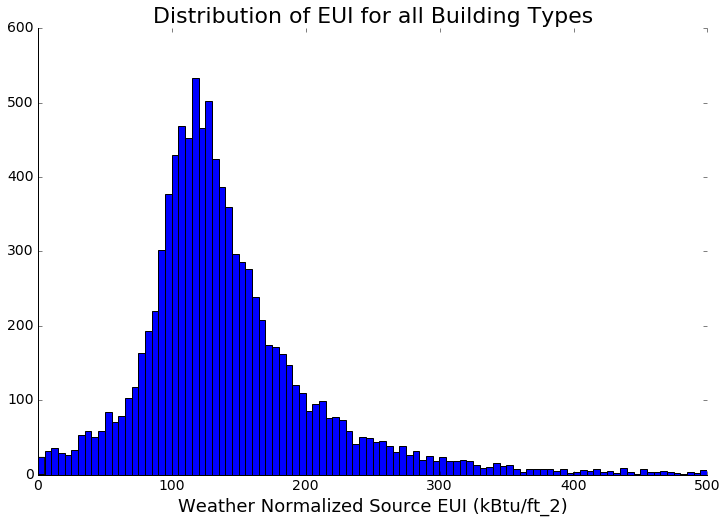

In [83]:
plt.hist(df.eui[df.eui < 500], bins=100)
plt.title('Distribution of EUI for all Building Types')
plt.xlabel(eui_label);

#### Figure 1: This shows the distribution of EUI for all building types. The mean of this distribution is approximately 141. 

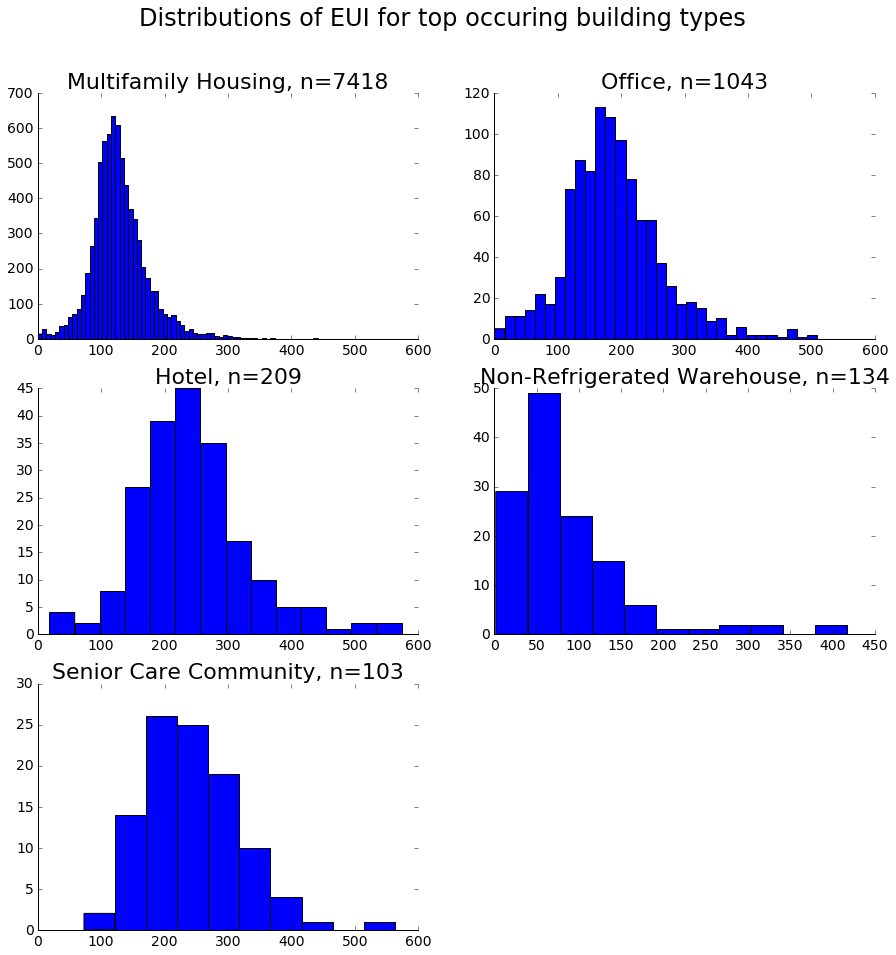

In [84]:
plt.figure(figsize=(15,15))
plt.suptitle('Distributions of EUI for top occuring building types', fontsize=24)
for i, (blg_type, n) in enumerate(top_blg_types.head().iteritems(), 1):
    plt.subplot(3,2,i)
    plt.title('{}, n={}'.format(blg_type, n))
    plt.hist(df[
        (df['Primary Property Type - Self Selected'] == blg_type) & (df.eui < 600)
    ].eui, bins=int(np.sqrt(n)))

#### Figure 2: This shows the distributions for the top 5 occuring building types. It can be seen that multifamily housing and offices have significantly more samples than the subsequent categories. Therefore, this analysis will focus on the former two.

In [85]:
%%report_change df dfmf
# Select only multifamily housing
dfmf = df[df['Primary Property Type - Self Selected'] == 'Multifamily Housing']
dfmf.describe()

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Street Number,Zip Code,Largest Property Use Type - Gross Floor Area (ft_2),Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),DEP Provided Water Use (kgal),eui,BBL,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,PolicePrct,HealthArea,SanitBoro,SanitDistr,LandUse,Easements,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,ProxCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,CondoNo,Tract2010,XCoord,YCoord,TaxMap,APPBBL,PLUTOMapID,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
count,7.418000e+03,7418.000000,7.418000e+03,6020.000000,7317.000000,7.418000e+03,7418.000000,7418.000000,6434.000000,7413.000000,7418.000000,7403.000000,6715.000000,7413.000000,7418.000000,6.715000e+03,6.715000e+03,7.403000e+03,7.403000e+03,7.416000e+03,7.416000e+03,7.418000e+03,7.317000e+03,7.418000e+03,4.783000e+03,4325.000000,4058.000000,7418.000000,7.418000e+03,7418.000000,7418.000000,7418.000000,7418.000000,7417.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7395.000000,7418.000000,7418.000000,7418.000000,7.418000e+03,7.418000e+03,7.418000e+03,7.418000e+03,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7.418000e+03,7.418000e+03,7.418000e+03,7.418000e+03,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7418.000000,7.418000e+03,7418.000000,7418.000000,7.418000e+03,7418.0,7418.000000,7418.000000,7.418000e+03
mean,3.505643e+06,6311.858183,2.217388e+09,1090.595515,10604.357524,1.410588e+05,1.391885,99.645457,56.478707,449.885067,449.758156,13.703607,2.436485,595.476649,594.019264,3.277569e+07,3.284033e+05,3.974506e+06,1.148125e+06,4.515926e+03,1.745515e+03,2.769664e+03,1.428407e+05,1.442245e+05,1.186961e+04,94.348247,6831.820158,594.019264,2.217388e+09,3000.447021,1282.223915,226.237665,307.891367,2490.896724,12.170801,18.321515,10604.755460,52.594365,3502.184281,2.260311,7.403613,3.279455,0.206929,3.851046e+04,1.424318e+05,9.522249e+03,1.254733e+05,1538.461310,3065.218523,2899.454974,263.762335,38.870315,1618.677811,2.001213,2.484362,10.314842,125.713535,127.939337,170.110725,158.963316,130.531804,105.151293,0.723376,3.713400,3.578458,1.423628e+06,8.299708e+06,2.709777e+05,1.912216e+06,1948.168239,604.169453,67.223376,6.522476,4.633222,1.017646,5.633305,2.187382,180.253033,8810.109059,1.002209e+06,214239.635886,22982.896603,4.115656e+08,1.0,1.131167,728.571285,3.880619e+04
std,8.309332e+05,3281.149325,1.182726e+09,1722.469018,566.258146,2.085517e+05,4.017049,3.284570,30.283919,10275.088982,10239.589084,210.563230,101.006151,11325.051186,11284.909196,1.463013e+09,1.462128e+07,3.264556e+07,9.552644e+06,9.219132e+04,7.396101e+04,5.498585e+04,2.738700e+05,2.121891e+05,8.904228e+04,901.643416,7100.225831,11284.909196,1.182726e+09,2495.873044,2765.777041,117.210383,270.632902,1522.856414,9.660215,14.627357,565.635933,34.540190,2510.815261,1.168395,3.825533,0.74491

Data Size: df before = 9802 samples, dfmf after = 7418 samples (∆-2384, -24.322%)


In [86]:
%%report_change
def clean(df, col='eui', use_log=True, nstd=2):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    if use_log:
        df = df[df[col] != 0]
        vals = np.log10(df[col].astype(float))
    else:
        vals = df[col].astype(float)
        
    return df[ np.abs(vals - np.mean(vals)) < nstd*np.std(vals) ]

print(dfmf.eui.describe())
dfmf = clean(dfmf, 'eui')
dfmf.eui.describe()

count      7418.000000
mean        594.019264
std       11284.909196
min           0.100000
25%         102.600000
50%         123.600000
75%         150.300000
max      838112.300000
Name: eui, dtype: float64


count    7264.000000
mean      130.278868
std        43.124621
min        35.700000
25%       103.400000
50%       123.900000
75%       150.000000
max       436.800000
Name: eui, dtype: float64

Data Size: df before = 9802 samples, df after = 9802 samples (∆0, 0.000%)


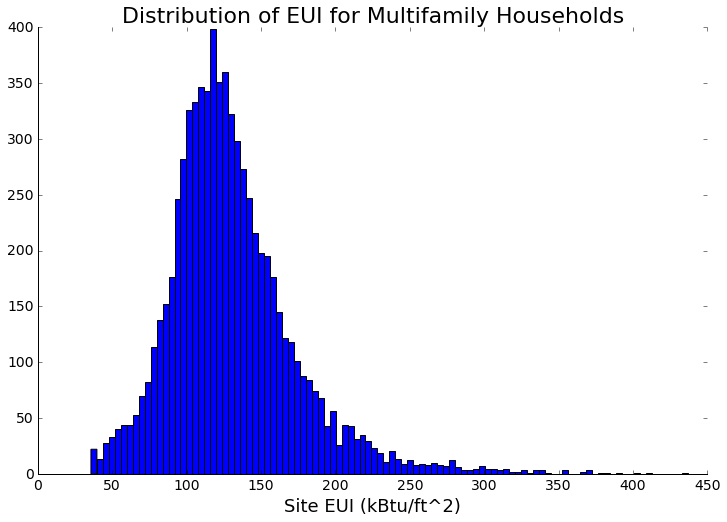

In [87]:
plt.hist(dfmf.eui, bins=100)
plt.title('Distribution of EUI for Multifamily Households')
plt.xlabel('Site EUI (kBtu/ft^2)')
plt.show()

#### Figure 3: This shows the distribution of EUI for multifamily households. The mean of this distribution is approximately 130. 

In [88]:
def makeCorrPlots(x, y, df):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    tmp = df[[x,y]]
    tmp = tmp.dropna()
    X, Y = tmp[x].astype(float), tmp[y]
    
    if not len(X) or not len(Y):
        return
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
    
    # plot2
    plt.scatter(X, Y, color=tableau20[0], alpha=0.5)
    plt.plot(X, intercept + slope*X, color='firebrick')
    plt.title('%s v. %s (corr= %.2f)' %(y, x, np.corrcoef(X, Y)[0][1]))

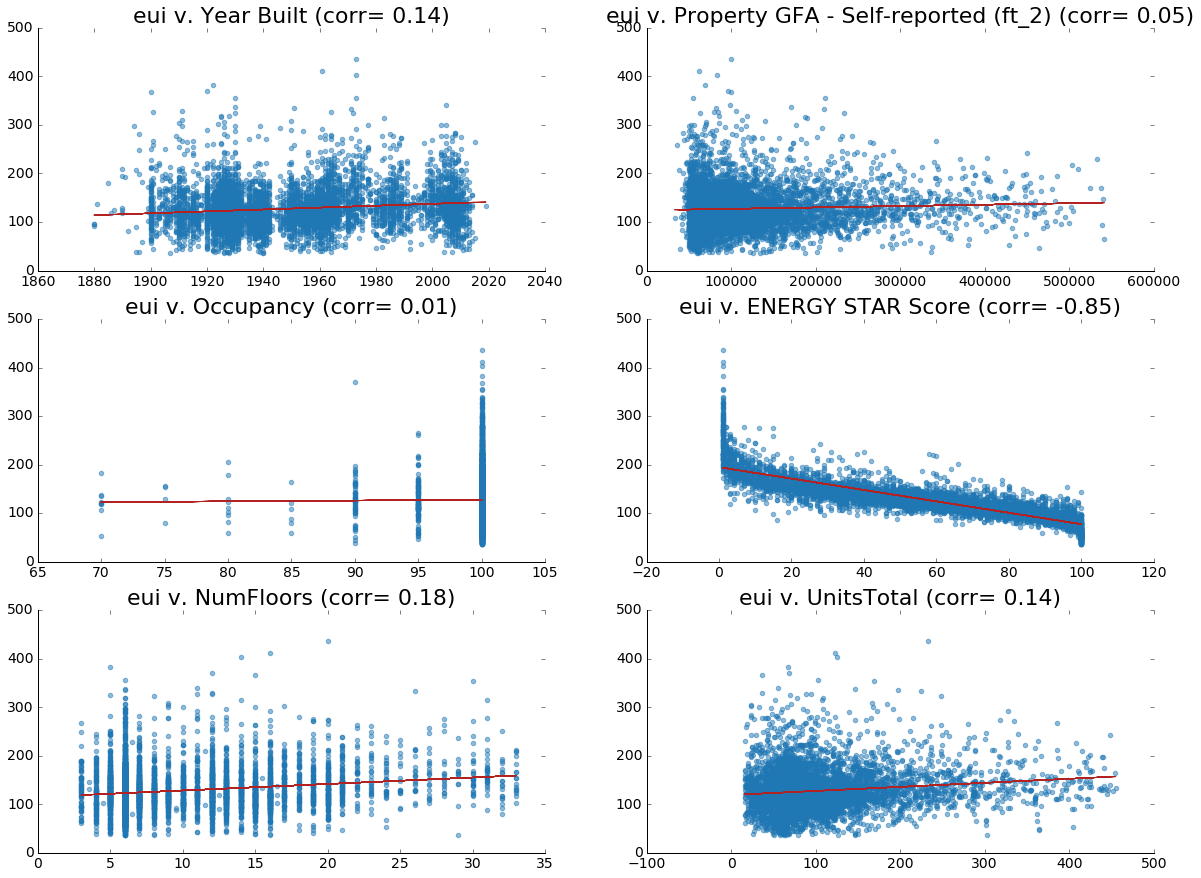

In [89]:
# Cleaning outliers
df2 = dfmf
for col in ['Year Built', 'Property GFA - Self-reported (ft_2)', 'NumFloors', 'UnitsTotal']:
    df2 = clean(df2, col, nstd=2.5)
df2 = df2[df2.Occupancy > 60]

plt.figure(figsize=(20,20))
for i, var in enumerate(['Year Built', 'Property GFA - Self-reported (ft_2)', 'Occupancy', 'ENERGY STAR Score', 'NumFloors', 'UnitsTotal'], 1):
    plt.subplot(4,2,i)
    makeCorrPlots(var, 'eui', df2)

#### Number of floors and the number of residential units are instinctively correlated, and this is shown in the correlation plots above, where both variables have similar correlation coefficients. Because number of floors is relatively more discrete than UnitsRes, UnitsRes should be used as it offers higher resolution. The Energy Star score shows a strong negative correlation, which speaks well for Energy Star as a rating system. It is expected that occupancy would show a correlation with energy usage, however, it is shown to have a correlation coefficient of 0. It appears that the energy usage doesn't increase per say, but the range of energy usage increases drastically as occupancy counts increase. This could be due to the variability in human behavior, or could be a function of occupancy density where families become for efficient per person (at varying degrees) as the number of occupants per unit increases.

In [90]:
%%report_change df dfof
# Select only offices
dfof = df[df['Primary Property Type - Self Selected'] == 'Office']
dfof.describe()

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Street Number,Zip Code,Largest Property Use Type - Gross Floor Area (ft_2),Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),DEP Provided Water Use (kgal),eui,BBL,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,PolicePrct,HealthArea,SanitBoro,SanitDistr,LandUse,Easements,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,ProxCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,CondoNo,Tract2010,XCoord,YCoord,TaxMap,APPBBL,PLUTOMapID,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
count,1.043000e+03,1043.000000,1.043000e+03,986.000000,1043.000000,1.043000e+03,1043.000000,1043.000000,956.000000,1043.000000,1043.000000,1041.000000,685.000000,1043.000000,1043.000000,6.850000e+02,6.850000e+02,1.041000e+03,1.041000e+03,1.043000e+03,1043.000000,1.043000e+03,1.043000e+03,1.043000e+03,659.00000,563.000000,275.000000,1043.000000,1.043000e+03,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1034.000000,1043.000000,1043.000000,1043.00000,1043.000000,1.043000e+03,1.043000e+03,1043.000000,1.043000e+03,1.043000e+03,1043.000000,1.043000e+03,1043.000000,1.043000e+03,1043.0,1043.000000,1043.000000,1043.000000,1043.00000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1.043000e+03,1.043000e+03,1.043000e+03,1.043000e+03,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1.043000e+03,1043.000000,1043.000000,1.043000e+03,1043.0,1043.000000,1043.000000,1043.000000
mean,3.134108e+06,2791.612656,1.352679e+09,445.220081,10163.999041,3.032736e+05,1.006711,97.531160,69.934100,825.053595,806.293193,32.649856,0.180876,1204.940268,1181.326750,3.930377e+06,3.916557e+04,2.182338e+07,6.352771e+06,1.233631e+04,272.791946,1.206352e+04,3.159697e+05,3.263232e+05,9586.62261,45.312575,2939.625818,1181.326750,1.352679e+09,1231.363375,743.903164,138.724832,115.033174,1569.257910,4.783317,6.896453,10163.652924,23.817833,4975.136146,1.405222,4.686481,5.122723,0.05465,27989.488974,3.102750e+05,3.068815e+05,3058.669223,2.565224e+05,2.036742e+04,5081.791946,8.203867e+03,3429.914669,1.140565e+04,2.0,1.129434,17.727709,3.066155,38.08629,133.484314,170.694727,116.205427,146.681457,1.305849,3.601151,2.889741,1.022156e+07,4.655793e+07,3.658206e+05,3.323987e+06,1935.441035,1158.599233,340.337488,13.367028,6.669070,9.813231,10.490240,1.340364,109.252157,1567.438159,9.904807e+05,210773.325983,13890.657718,2.409795e+08,1.0,0.656759,649.015824,28946.328919
std,9.303114e+05,2846.077485,8.936513e+08,604.527827,382.405475,3.951366e+05,0.127553,9.315217,22.952189,9084.081368,8945.505950,582.044187,0.272092,12344.790639,12197.446505,1.294679e+07,1.283826e+05,1.068732e+08,3.131166e+07,1.301126e+05,629.130864,1.301298e+05,4.113684e+05,4.251678e+05,35884.18817,296.289776,3087.676097,12197.446505,8.936513e+08,1546.961955,2189.913855,88.868501,142.547636,994.150279,7.276090,9.856690,382.481315,28.285245,1713.855487,0.906688,2.493077,0.690136,0.32474,49255.370125,3.969226

Data Size: df before = 9802 samples, dfof after = 1043 samples (∆-8759, -89.359%)


In [91]:
%%report_change
print(dfof.eui.describe())
dfof = clean(dfof, 'eui')
dfof.eui.describe()

count      1043.000000
mean       1181.326750
std       12197.446505
min           0.300000
25%         141.200000
50%         182.800000
75%         229.300000
max      272690.200000
Name: eui, dtype: float64


count    1010.000000
mean      196.103663
std        89.905716
min        33.700000
25%       143.825000
50%       182.900000
75%       228.350000
max       985.100000
Name: eui, dtype: float64

Data Size: df before = 9802 samples, df after = 9802 samples (∆0, 0.000%)


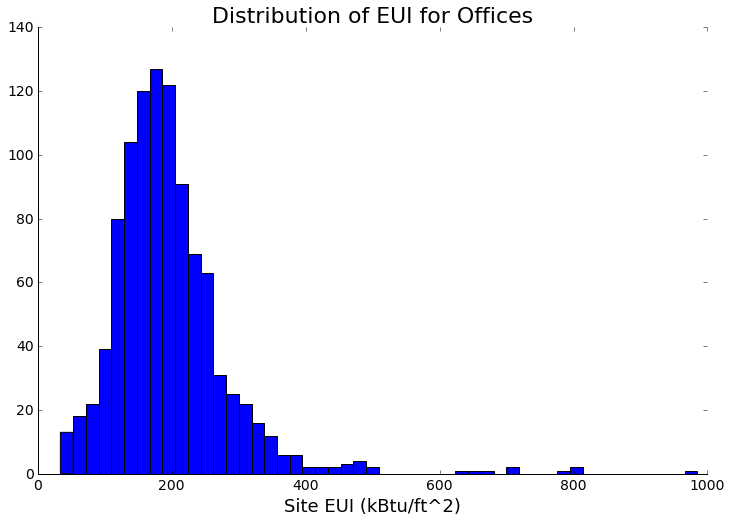

In [92]:
plt.hist(dfof.eui, bins=50)
plt.title('Distribution of EUI for Offices')
plt.xlabel('Site EUI (kBtu/ft^2)')
plt.show()

#### Figure 4: This shows the distribution of EUI for office buildings. The mean of this distribution is approximately 196. 

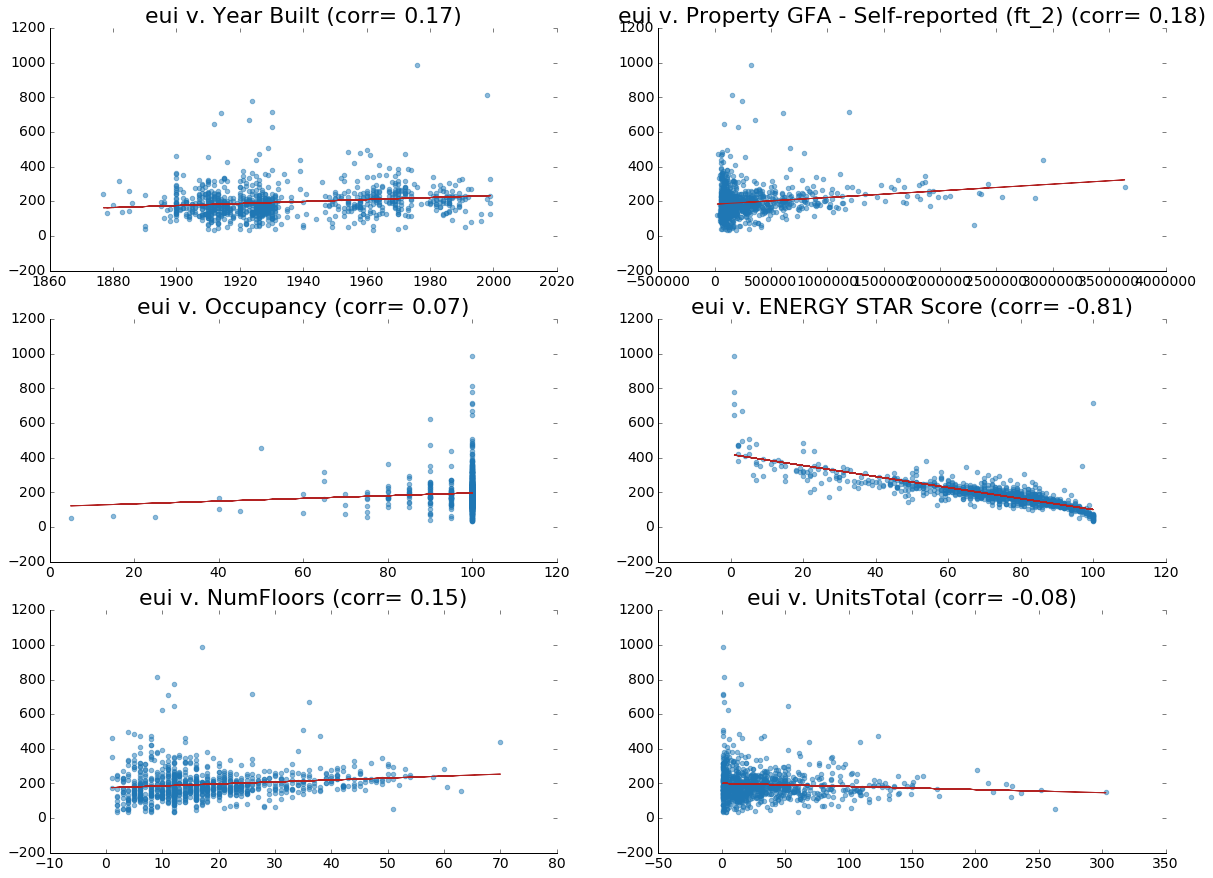

Data Size: dfof before = 1010 samples, df2 after = 932 samples (∆-78, -7.723%)


In [93]:
%%report_change dfof df2
# Cleaning outliers
df2 = dfof
for col in ['Year Built', 'UnitsTotal']:
    df2 = clean(df2, col)

plt.figure(figsize=(20,20))
for i, var in enumerate(['Year Built', 'Property GFA - Self-reported (ft_2)', 'Occupancy', 'ENERGY STAR Score', 'NumFloors', 'UnitsTotal'], 1):
    plt.subplot(4,2,i)
    makeCorrPlots(var, 'eui', df2)

#### Property gross floor area, year built, and the number of floors all show visibly strong relationships with the EUI. Occupancy shows a bit of a positive relationship with EUI, however, as the number of occupants increase, so does the uncertainty, where the maximum energy usage is increasing, but the minimum energy usage stays relatively constant for all occupancy counts. 

## Modeling

#### How can we develop a metric for understanding energy performance and peer building comparison that accounts for the differences in building and occupancy characteristics that impact consumption?

### Multifamily Housing Regression

In [94]:
dfmf['year'] = 2017 - dfmf['Year Built'].astype(int)
dfmf['area'] = dfmf['Property GFA - Self-reported (ft_2)']
lm_mf = smf.ols('eui ~ UnitsTotal + year + area', data=dfmf).fit()
lm_mf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     104.4
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           3.68e-66
Time:                        07:26:39   Log-Likelihood:                -37496.
No. Observations:                7264   AIC:                         7.500e+04
Df Residuals:                    7260   BIC:                         7.503e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    140.4852      1.358    103.429      0.000     137.823     143.148
UnitsTotal     0.0175      0.003      5.799      0.000       0.012       0.023
year          -0.2069      0.017    -11.855      0.000      -0.241      -0.173
area        9.573e-06   3.33e-06      2.878      0.004    3.05e-06    1.61e-05
==============================================================================
Omnibus:                     2019.763   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7971.129
Skew:                           1.332   Prob(JB):                         0.00
Kurtosis:                       7.386   Cond. No.                     6.99e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Run Office Regression

In [95]:
dfof['year'] = 2017 - dfof['Year Built'].astype(int)
dfof['area'] = dfof['Property GFA - Self-reported (ft_2)']
lm_of = smf.ols('eui ~ NumFloors + year + area', data=dfof).fit()
lm_of.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     16.68
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           1.40e-10
Time:                        07:26:39   Log-Likelihood:                -5951.9
No. Observations:                1010   AIC:                         1.191e+04
Df Residuals:                    1006   BIC:                         1.193e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    217.8597     10.323     21.105      0.000     197.604     238.116
NumFloors     -0.0121      0.352     -0.034      0.973      -0.704       0.680
year          -0.3838      0.094     -4.063      0.000      -0.569      -0.198
area        2.929e-05      1e-05      2.927      0.003    9.65e-06    4.89e-05
==============================================================================
Omnibus:                      678.863   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11686.607
Skew:                           2.840   Prob(JB):                         0.00
Kurtosis:                      18.667   Cond. No.                     1.99e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Improved Office Regression

In [96]:
dfof['year'] = 2017 - dfof['Year Built'].astype(int)
dfof['area'] = dfof['Property GFA - Self-reported (ft_2)']
lm_of = smf.ols('eui ~ year + area', data=dfof).fit()
lm_of.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     25.05
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           2.42e-11
Time:                        07:26:39   Log-Likelihood:                -5951.9
No. Observations:                1010   AIC:                         1.191e+04
Df Residuals:                    1007   BIC:                         1.192e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    217.6835      8.964     24.285      0.000     200.094     235.273
year          -0.3833      0.093     -4.106      0.000      -0.567      -0.200
area        2.904e-05   6.87e-06      4.226      0.000    1.56e-05    4.25e-05
==============================================================================
Omnibus:                      679.083   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11694.916
Skew:                           2.841   Prob(JB):                         0.00
Kurtosis:                      18.672   Cond. No.                     1.73e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
# Store the predicted values
dfmf['benchmark'] = lm_mf.fittedvalues
# Store the difference between the predicted values and the actual values
dfmf['difference'] = dfmf.eui - dfmf.benchmark

## Visualization

In [98]:
gdfPLUTO = gpd.GeoDataFrame(dfPLUTO)
gdfmf = gpd.GeoDataFrame(dfmf)

# vmin, vmax = gdfmf.benchmark.min(), gdfmf.benchmark.max()
# cmap = 'hot'
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []

In [100]:
# Prep for carto
gdfmf.crs = {'init' :'epsg:2263'}
gdfmf = gdfmf.to_crs({'init' :'epsg:4326'})[['eui', 'benchmark', 'difference', 'geometry']]
gdfmf['the_geom'] = gdfmf['geometry']
gdfmf.to_csv('gdfmf.csv')

### After many headaches with geopandas and folium, I've decided to visualize using Carto.